In [1]:
import numpy as np
import pandas as pd

### Import dataset


In [2]:
df_raw = pd.read_csv('./data/concrete_data.csv')
df_raw.head(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### Pre-processiong

In [3]:
print(df_raw.shape)
print(df_raw.isnull().sum())

df = df_raw.copy()

(1030, 9)
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64


<AxesSubplot:ylabel='Frequency'>

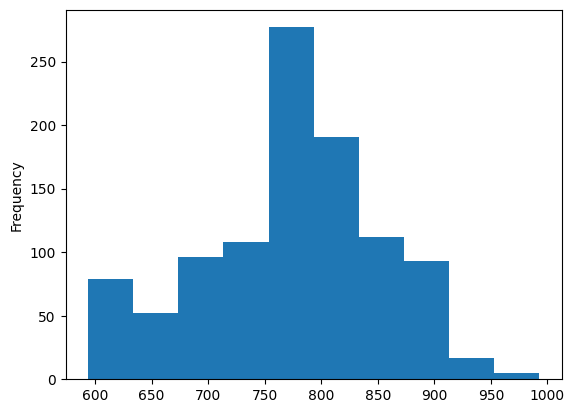

In [4]:
df['Fine Aggregate'].plot(kind='hist')

##### Basic stats

In [5]:
all_columns = df.columns
print(f'All columns: {all_columns}')

unwanted_columns = ['Cement', 'Strength']
feature_columns = [col for col in all_columns if col not in unwanted_columns]
print(f'Feature Columns: {feature_columns}')

df.loc[:, feature_columns].describe()

All columns: Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')
Feature Columns: ['Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']


,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136
std,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912
min,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000
50%,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000
75%,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000
max,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000


##### Correlation

In [6]:
df_corr = df.loc[:, feature_columns].corr()
df_corr.style.applymap(lambda x: 'background-color: yellow' if x > 0.7 else '')

,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Blast Furnace Slag,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246
Fly Ash,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371
Water,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618
Superplasticizer,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700
Coarse Aggregate,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016
Fine Aggregate,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095
Age,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000


In [7]:
df['Age'] = df['Age'].apply(pd.to_numeric, downcast='float')

### Split into train-validate-test sets

In [8]:
n = df.shape[0] // 10

column_list = list(all_columns)
column_list.remove('Cement')
df_population = df.loc[:, column_list].copy()

df_test = df_population.sample(n=n)
df_population.drop(df_test.index, inplace=True)
df_validate = df_population.sample(n=n)
df_train = df_population.drop(df_validate.index)

df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)

print(f'Train size: {df_train.shape}')
print(f'Test size: {df_test.shape}')
print(f'Validate size: {df_validate.shape}')

Train size: (824, 8)
Test size: (103, 8)
Validate size: (103, 8)


### Setup and Compare

In [9]:
from pycaret.regression import *
exp_reg1 = setup(
    data=df_train, target='Strength', test_data=df_validate, normalize=True, session_id=101, transformation=True,
    transform_target=True, 
    )

,Description,Value
0,session_id,101
1,Target,Strength
2,Original Data,"(824, 8)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(824, 20)"


In [10]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,6.1380,70.9901,8.2223,0.6303,0.2617,0.2230,0.0280
et,Extra Trees Regressor,6.0478,74.0122,8.3514,0.6200,0.2677,0.2190,0.0930
rf,Random Forest Regressor,6.8783,86.2888,8.9845,0.5638,0.2812,0.2422,0.1270
gbr,Gradient Boosting Regressor,7.4856,96.6841,9.5203,0.5022,0.2900,0.2575,0.0380
ridge,Ridge Regression,7.2740,89.9287,9.3268,0.4944,0.3013,0.2720,0.0190
br,Bayesian Ridge,7.2751,90.1901,9.3380,0.4926,0.3014,0.2717,0.0110
lr,Linear Regression,7.2939,90.9169,9.3730,0.4883,0.3018,0.2718,0.8130
lar,Least Angle Regression,7.3363,92.0078,9.4065,0.4870,0.3013,0.2705,0.0120
huber,Huber Regressor,7.2103,90.8855,9.3033,0.4852,0.2950,0.2655,0.0240
ada,AdaBoost Regressor,10.0564,157.0012,12.3140,0.1736,0.3817,0.3718,0.0430


PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

In [11]:
results = pull()
results.Model.head(2)

lightgbm    Light Gradient Boosting Machine
et                    Extra Trees Regressor
Name: Model, dtype: object

### Select Extra Trees and Light Gradient Boosting Machine models

In [12]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.2097,79.2499,8.9022,0.4057,0.2439,0.1852
1,10.1175,158.3778,12.5848,0.5330,0.2237,0.1811
2,5.6200,54.7798,7.4013,0.6147,0.2597,0.2202
3,8.4782,110.0743,10.4916,0.5501,0.2563,0.1943
4,6.3485,70.7973,8.4141,0.6184,0.2156,0.1609
5,6.0925,65.8658,8.1158,0.6429,0.3187,0.3019
6,4.2194,27.2308,5.2183,0.8307,0.3864,0.4106
7,5.7099,91.3690,9.5587,0.5685,0.3221,0.2464
8,3.2036,38.2469,6.1844,0.7445,0.2188,0.1414


In [13]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.5893,62.9295,7.9328,0.5281,0.2016,0.1630
1,7.9274,116.3221,10.7853,0.6570,0.1962,0.1438
2,5.4247,59.0616,7.6852,0.5846,0.2583,0.2153
3,9.0725,129.4709,11.3785,0.4708,0.2891,0.2209
4,7.5352,88.1514,9.3889,0.5249,0.2257,0.1954
5,5.6086,58.7911,7.6675,0.6812,0.2861,0.2609
6,4.3577,28.0207,5.2935,0.8258,0.3877,0.4139
7,5.6809,82.1971,9.0663,0.6119,0.3166,0.2502
8,4.4295,39.2051,6.2614,0.7381,0.2167,0.1751


### Tune both 

In [14]:
tuned_et = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.3447,114.5461,10.7026,0.1410,0.3135,0.2084
1,13.9424,266.6332,16.3289,0.2138,0.3003,0.2498
2,5.8043,53.9854,7.3475,0.6203,0.2653,0.2432
3,9.4129,150.3173,12.2604,0.3856,0.2634,0.1979
4,7.0626,88.1481,9.3887,0.5249,0.2520,0.1882
5,7.0514,77.4493,8.8005,0.5801,0.3435,0.3487
6,7.5461,81.4896,9.0272,0.4935,0.5608,0.7333
7,8.4718,142.7341,11.9471,0.3260,0.3977,0.3307
8,9.4508,142.5882,11.9410,0.0475,0.4141,0.4185


In [15]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.4875,58.0405,7.6184,0.5647,0.1953,0.1666
1,7.8590,102.2899,10.1138,0.6984,0.1986,0.1551
2,7.3312,85.4345,9.2431,0.3991,0.3043,0.2606
3,8.8982,130.1194,11.4070,0.4681,0.2625,0.1983
4,9.7420,136.7073,11.6922,0.2632,0.2953,0.2467
5,6.7118,73.3446,8.5641,0.6023,0.3310,0.3320
6,5.6091,44.2402,6.6513,0.7250,0.4248,0.4777
7,6.9058,94.0975,9.7004,0.5557,0.3260,0.2802
8,7.0558,77.9407,8.8284,0.4794,0.3102,0.2914


In [16]:
tuned_et2 = tune_model(et, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.8213,100.9993,10.0498,0.2426,0.2945,0.1949
1,12.6840,226.9555,15.0650,0.3308,0.2717,0.2275
2,5.4041,49.6169,7.0439,0.6510,0.2531,0.2222
3,9.1059,134.9064,11.6149,0.4485,0.2529,0.1933
4,6.7885,80.4922,8.9717,0.5662,0.2360,0.1785
5,6.2621,64.2840,8.0177,0.6514,0.3193,0.3118
6,6.0984,58.3095,7.6361,0.6376,0.5081,0.6180
7,7.7260,117.6554,10.8469,0.4444,0.3628,0.3014
8,7.9379,98.5177,9.9256,0.3419,0.3452,0.3353


Select ET for ensembling

In [17]:
bagged_et = ensemble_model(et, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.9598,99.8455,9.9923,0.2512,0.3005,0.2059
1,11.5899,194.7688,13.9560,0.4257,0.2461,0.2032
2,5.5819,51.3184,7.1637,0.6391,0.2550,0.2229
3,8.8768,123.7493,11.1243,0.4942,0.2533,0.1940
4,6.3109,67.4366,8.2120,0.6365,0.2195,0.1664
5,5.9263,61.7179,7.8561,0.6654,0.3132,0.2954
6,5.0256,40.0122,6.3255,0.7513,0.4542,0.5187
7,6.2513,100.3458,10.0173,0.5262,0.3368,0.2596
8,4.8860,50.6554,7.1173,0.6616,0.2581,0.2127


In [18]:
boosted_et = ensemble_model(et, method='Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.7893,91.8897,9.5859,0.3109,0.2725,0.1962
1,12.3279,227.7732,15.0922,0.3284,0.2655,0.2130
2,5.2735,47.8453,6.9170,0.6635,0.2482,0.2127
3,8.3540,111.3484,10.5522,0.5448,0.2419,0.1854
4,6.5822,77.0922,8.7802,0.5845,0.2219,0.1656
5,5.9817,63.8228,7.9889,0.6539,0.3093,0.2906
6,4.2359,28.3709,5.3264,0.8237,0.3910,0.4147
7,6.1338,97.2878,9.8635,0.5406,0.3303,0.2526
8,3.6803,40.6499,6.3757,0.7285,0.2267,0.1576


### Blend ET and LGBM AND ET and Ensembled ET

In [19]:
blended_model = blend_models(estimator_list=[et, lgbm])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.7480,64.4244,8.0265,0.5169,0.2079,0.1674
1,8.8506,129.8544,11.3954,0.6171,0.2012,0.1566
2,5.1882,50.2940,7.0918,0.6463,0.2498,0.2095
3,8.2659,108.3085,10.4071,0.5573,0.2586,0.1960
4,6.4130,67.2332,8.1996,0.6376,0.2051,0.1657
5,5.6776,57.5517,7.5863,0.6879,0.2962,0.2738
6,4.0694,25.1612,5.0161,0.8436,0.3833,0.4045
7,5.5426,84.2038,9.1763,0.6024,0.3128,0.2432
8,3.7369,34.9529,5.9121,0.7665,0.2108,0.1557


In [20]:
blended_model2 = blend_models(estimator_list=[et, bagged_et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.5875,88.4136,9.4028,0.3370,0.2697,0.1956
1,10.8368,175.0079,13.2291,0.4840,0.2334,0.1907
2,5.5587,52.3412,7.2347,0.6319,0.2561,0.2200
3,8.6301,114.6037,10.7053,0.5315,0.2504,0.1923
4,6.3170,68.5772,8.2811,0.6304,0.2161,0.1633
5,5.9859,63.2158,7.9508,0.6572,0.3148,0.2974
6,4.5882,32.5891,5.7087,0.7974,0.4197,0.4616
7,5.9487,95.2313,9.7587,0.5503,0.3277,0.2522
8,4.0117,42.4802,6.5177,0.7162,0.2344,0.1758


### Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


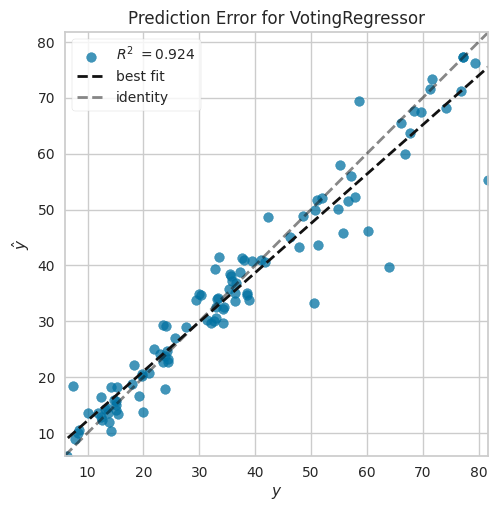

In [21]:
plot_model(blended_model, plot='error')

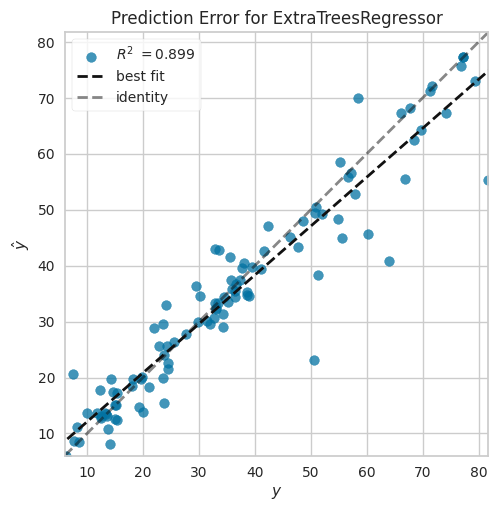

In [22]:
plot_model(et, plot='error')

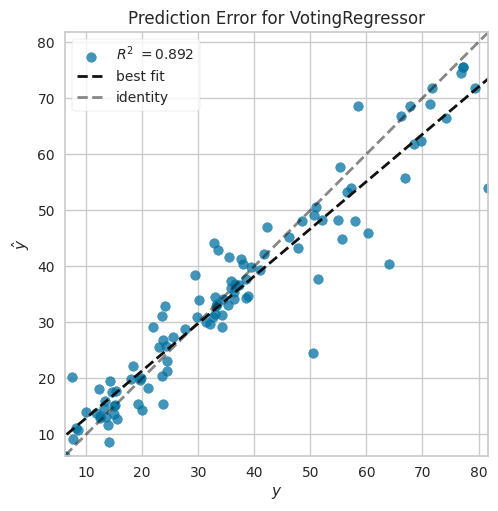

In [23]:
plot_model(blended_model2, plot='error')

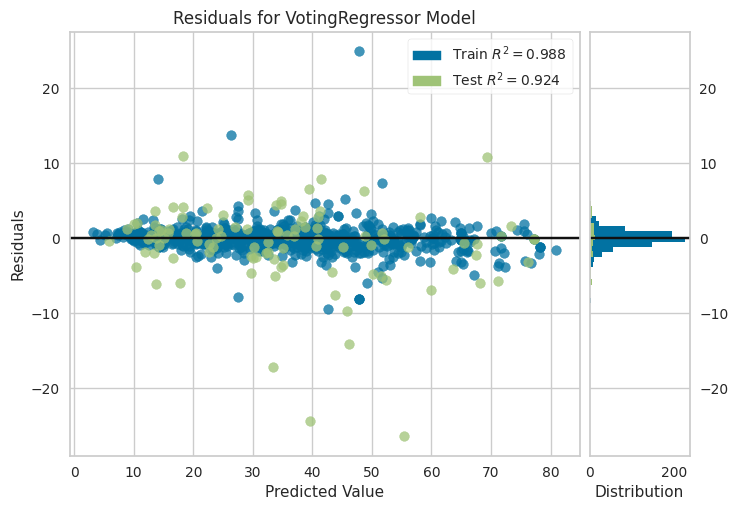

In [24]:
plot_model(blended_model, plot='residuals')

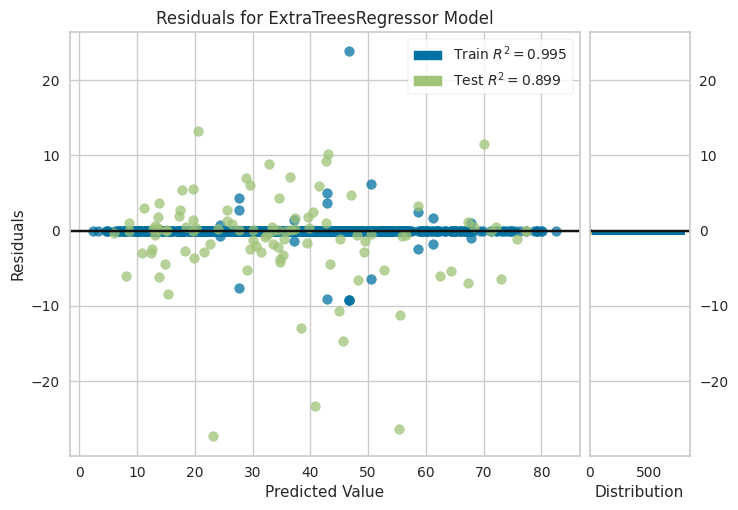

In [25]:
plot_model(et, plot='residuals')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


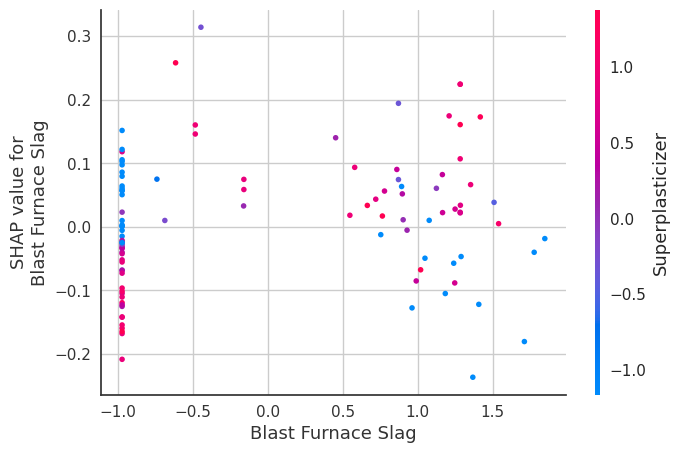

In [26]:
interpret_model(et, plot='correlation')

### Use test set for predictions

In [27]:
predict_model(blended_model, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.9112,17.7916,4.2180,0.9416,0.1337,0.1041


,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,Label
549,0.0,0.0,192.0,0.0,931.2,842.6,90,41.68,38.455587
905,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,13.837311
880,0.0,112.0,184.0,8.0,992.0,816.0,28,12.18,14.481713
960,119.7,0.0,168.3,7.2,970.4,794.2,28,40.93,41.648731
74,93.8,0.0,126.6,23.4,852.1,992.6,3,29.00,34.977630
...,...,...,...,...,...,...,...,...,...
344,0.0,174.7,154.8,10.2,1053.5,776.4,3,17.57,17.981496
80,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40,34.215191
331,0.0,125.1,143.3,12.0,1086.8,800.9,28,52.50,46.896724
863,121.0,0.0,177.0,7.0,908.0,829.0,28,42.13,40.613897


In [28]:
predict_model(et, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.6184,28.1092,5.3018,0.9077,0.1543,0.1211


,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,Label
549,0.0,0.0,192.0,0.0,931.2,842.6,90,41.68,36.970747
905,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,14.232022
880,0.0,112.0,184.0,8.0,992.0,816.0,28,12.18,12.815965
960,119.7,0.0,168.3,7.2,970.4,794.2,28,40.93,41.077614
74,93.8,0.0,126.6,23.4,852.1,992.6,3,29.00,36.940572
...,...,...,...,...,...,...,...,...,...
344,0.0,174.7,154.8,10.2,1053.5,776.4,3,17.57,16.524855
80,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40,33.400002
331,0.0,125.1,143.3,12.0,1086.8,800.9,28,52.50,43.932286
863,121.0,0.0,177.0,7.0,908.0,829.0,28,42.13,42.105632


### Use gradio to demo predictions

In [29]:
import gradio as gr

In [30]:
def predict_strength():
   predictions = predict_model(et, data=df_test) 
   return predictions

gr.Interface(predict_strength, [], "dataframe").launch()

Running on local URL:  http://127.0.0.1:7861/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fee4552ad90>, 'http://127.0.0.1:7861/', None)